In [8]:
conda install pytorch::pytorch torchvision torchaudio -c pytorch

Retrieving notices: ...working... done
Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import os

In [34]:
#Check current directory and access images 
os.listdir('./EuroSAT_RGB')

# Define the correct path to the parent directory containing class folders
training_dataset_path = './EuroSAT_RGB'

In [40]:
# Normalize images to 224x224 pixels and convert them to a tensor
training_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Define the training dataset
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=training_transforms)

# Make Dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)


In [42]:
#Calculate mean and standard deviation
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    return mean, std


In [44]:
get_mean_and_std(train_loader)

(tensor([0.3446, 0.3806, 0.4081]), tensor([0.0900, 0.0618, 0.0512]))

In [46]:
# Mean and standard deviation values
mean = [0.3446, 0.3806, 0.4081]
std = [0.0900, 0.0618, 0.0512]

# Define the correct path to the parent directory containing class folders
dataset_path = './EuroSAT_RGB'

# Transforms for training dataset
training_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

# Transforms for test dataset
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

# Load the entire dataset with the training transforms initially
full_dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=training_transforms)

# Calculate the sizes for training and testing datasets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset into training and test sets
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Update the transform for the test dataset
test_dataset.dataset.transform = test_transforms

# Create data loaders for training and testing using the mini-batch gradient descent algorithm
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [52]:
# Use GPU for parallel processing
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else: 
        dev = "cpu"
    return torch.device(dev)

In [54]:
# Train the model (ResNet18 model - already trained on ImageNet dataset)

import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim

resnet18_model = models.resnet18(weights=None)
num_features = resnet18_model.fc.in_features
num_of_classes = 10
#Linear - function that takes the number of input and output variables as parameters and prepare the necessary matrices for forward propagation
resnet18_model.fc = nn.Linear(num_features, num_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
#Loss function - shows the error in the training process too see how close we are to the correctness of the classifications
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003) 

    

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision

# Get class names from the test dataset
class_names = test_loader.dataset.dataset.classes

def evaluate_model_on_test_set(model, test_loader, class_names):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    all_labels = []
    all_preds = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data 
            images = images.to(device) 
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
    print(" - Testing dataset got %d out of %d images correctly (%.3f%%)." % (predicted_correctly_on_epoch, total, epoch_acc))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy array and rearrange the dimensions
    img = img * std + mean  # Unnormalize using the mean and std
    img = np.clip(img, 0, 1)  # Clip the values to ensure they are in the correct range [0, 1]
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Train the neural network
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, class_names):
    device = set_device()
    
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0.0

        for i, data in enumerate(train_loader, 0):
            images, labels = data 
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print(" - Training dataset got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))

        evaluate_model_on_test_set(model, test_loader, class_names)
        
        if epoch % 1 == 0:  # Display images every epoch
            with torch.no_grad():
                model.eval()  # Set model to evaluation mode
                test_images, test_labels = next(iter(test_loader))
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # Display images
                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))

                # Make predictions
                test_outputs = model(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
                
                print('Actual:', ' '.join('%s' % class_names[test_labels[j]] for j in range(8)))
                print('Predicted:', ' '.join('%s' % class_names[predicted[j]] for j in range(8)))

                model.train()  # Set model back to training mode

    print("Finished")
    return model

Epoch number 1 
 - Training dataset got 19948 out of 21600 images correctly (92.352%). Epoch loss: 0.230
 - Testing dataset got 4359 out of 5400 images correctly (80.722%).


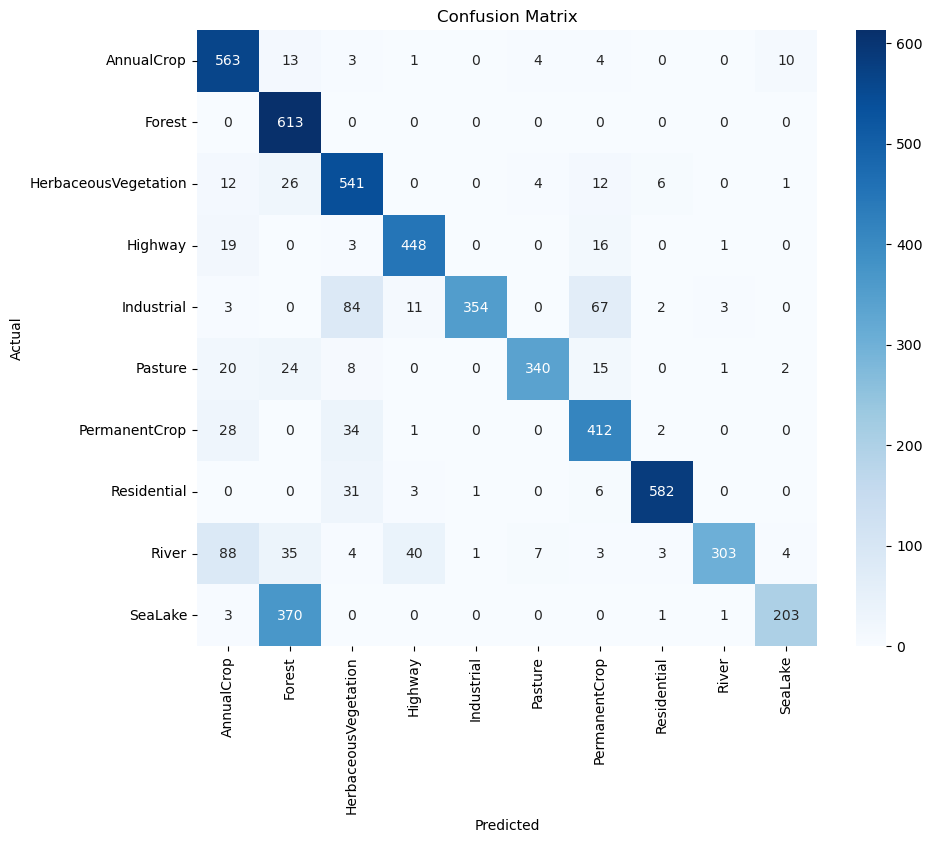

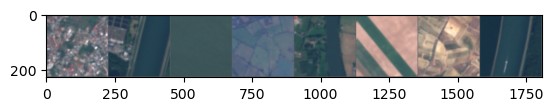

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture Pasture AnnualCrop PermanentCrop River
Epoch number 2 
 - Training dataset got 20001 out of 21600 images correctly (92.597%). Epoch loss: 0.225
 - Testing dataset got 4857 out of 5400 images correctly (89.944%).


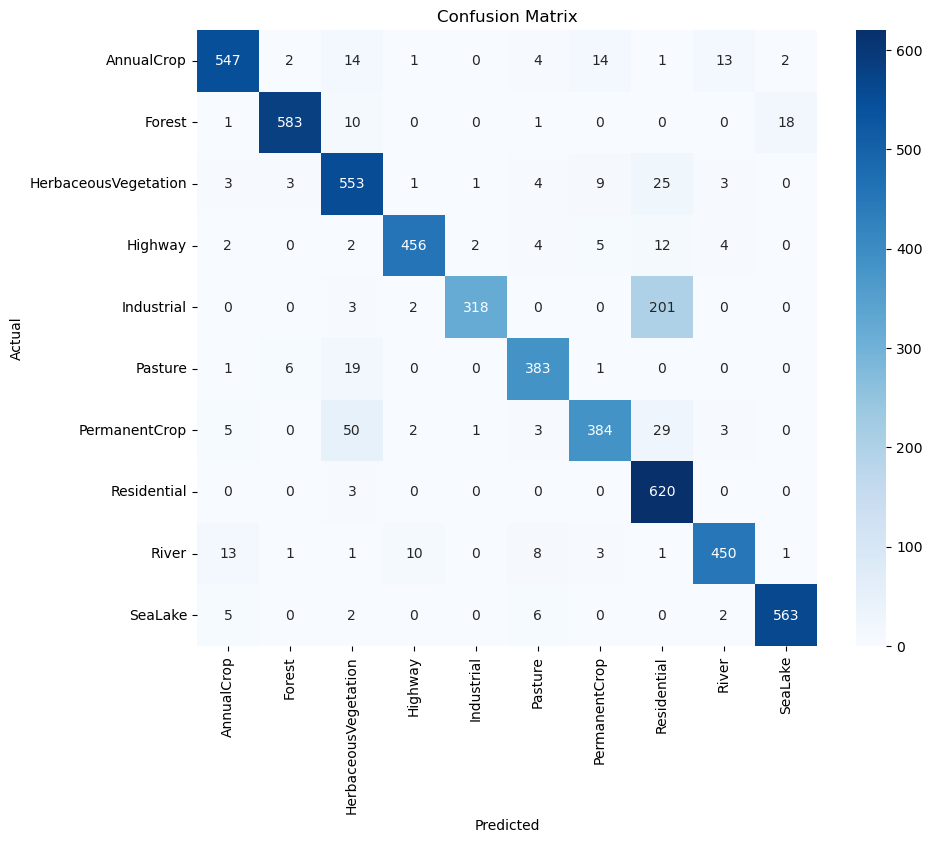

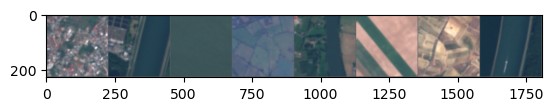

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 3 
 - Training dataset got 20072 out of 21600 images correctly (92.926%). Epoch loss: 0.208
 - Testing dataset got 4978 out of 5400 images correctly (92.185%).


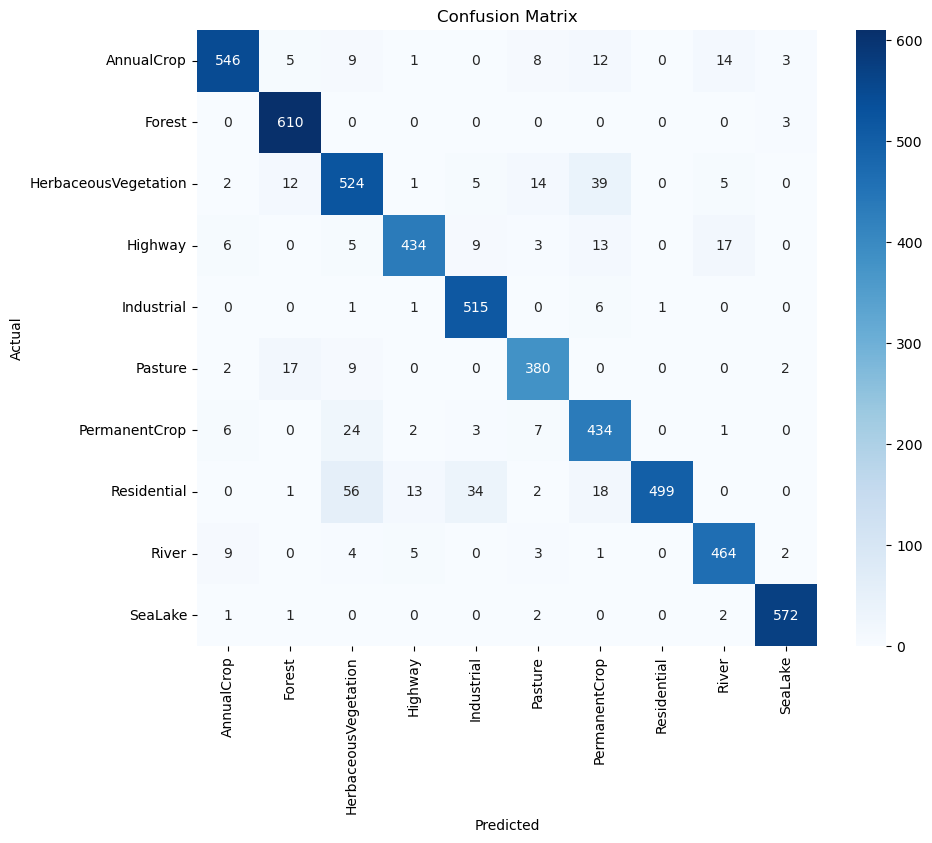

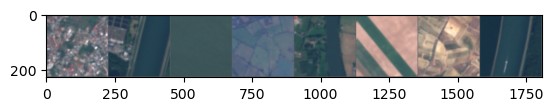

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Industrial River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 4 
 - Training dataset got 20127 out of 21600 images correctly (93.181%). Epoch loss: 0.207
 - Testing dataset got 5056 out of 5400 images correctly (93.630%).


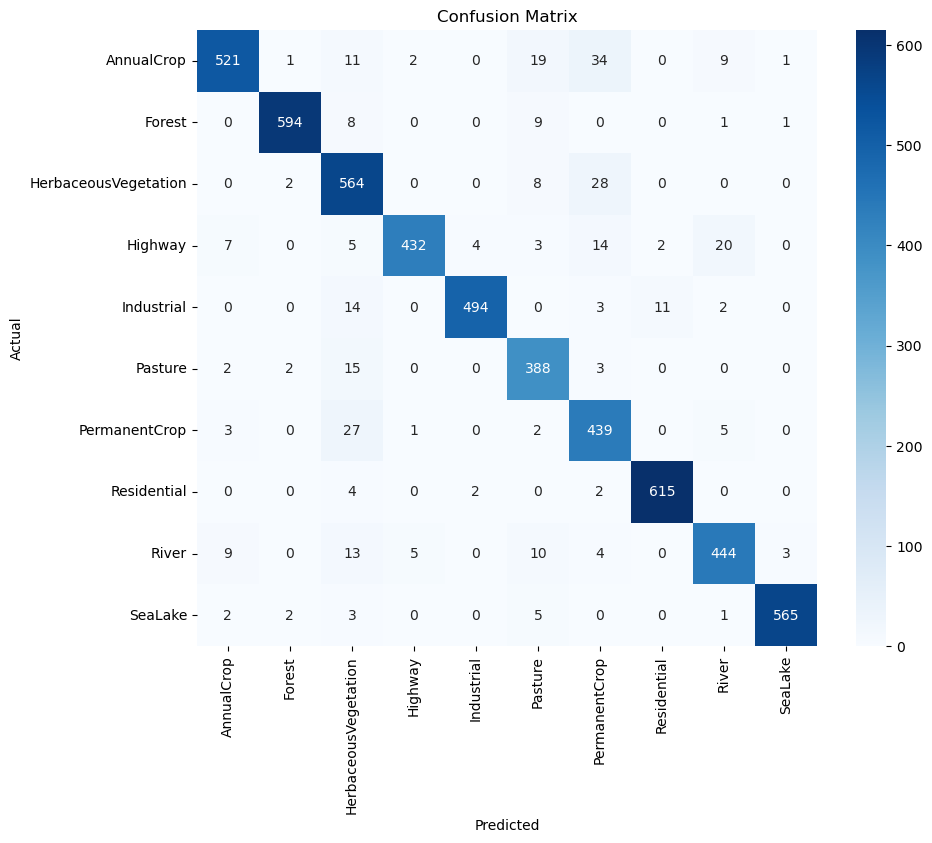

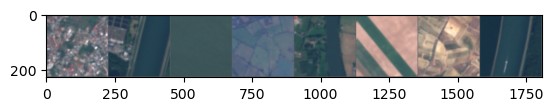

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 5 
 - Training dataset got 20237 out of 21600 images correctly (93.690%). Epoch loss: 0.194
 - Testing dataset got 4768 out of 5400 images correctly (88.296%).


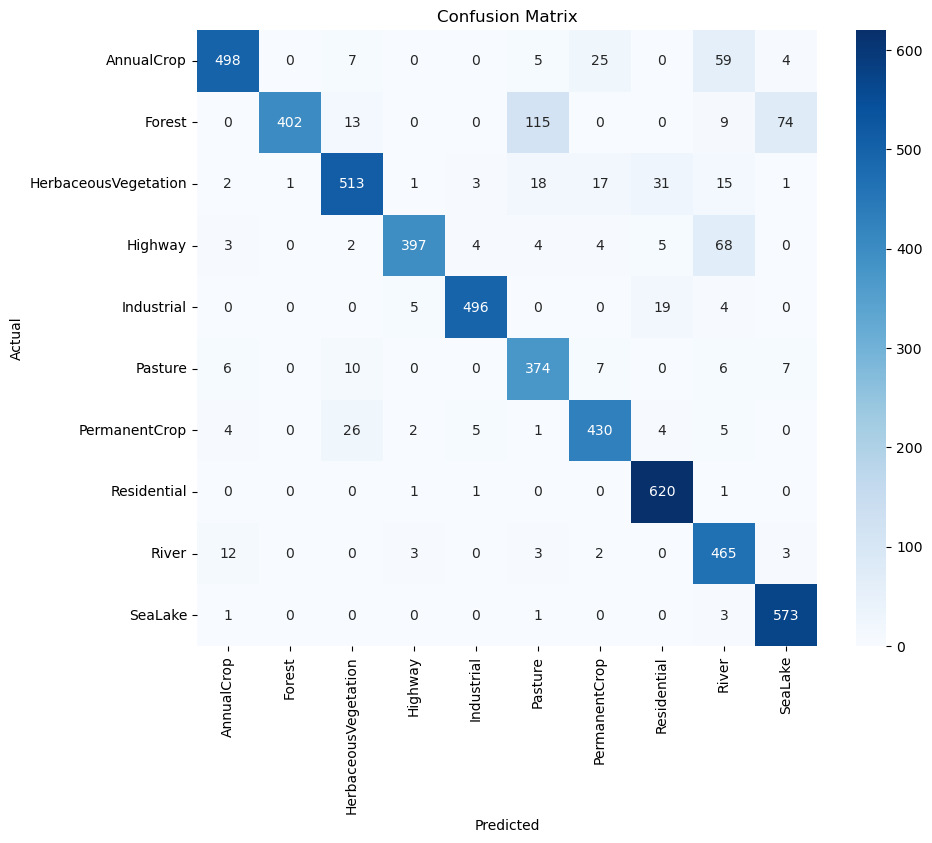

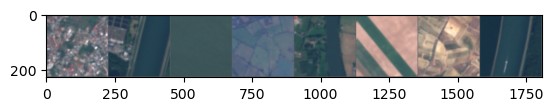

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 6 
 - Training dataset got 20339 out of 21600 images correctly (94.162%). Epoch loss: 0.184
 - Testing dataset got 4974 out of 5400 images correctly (92.111%).


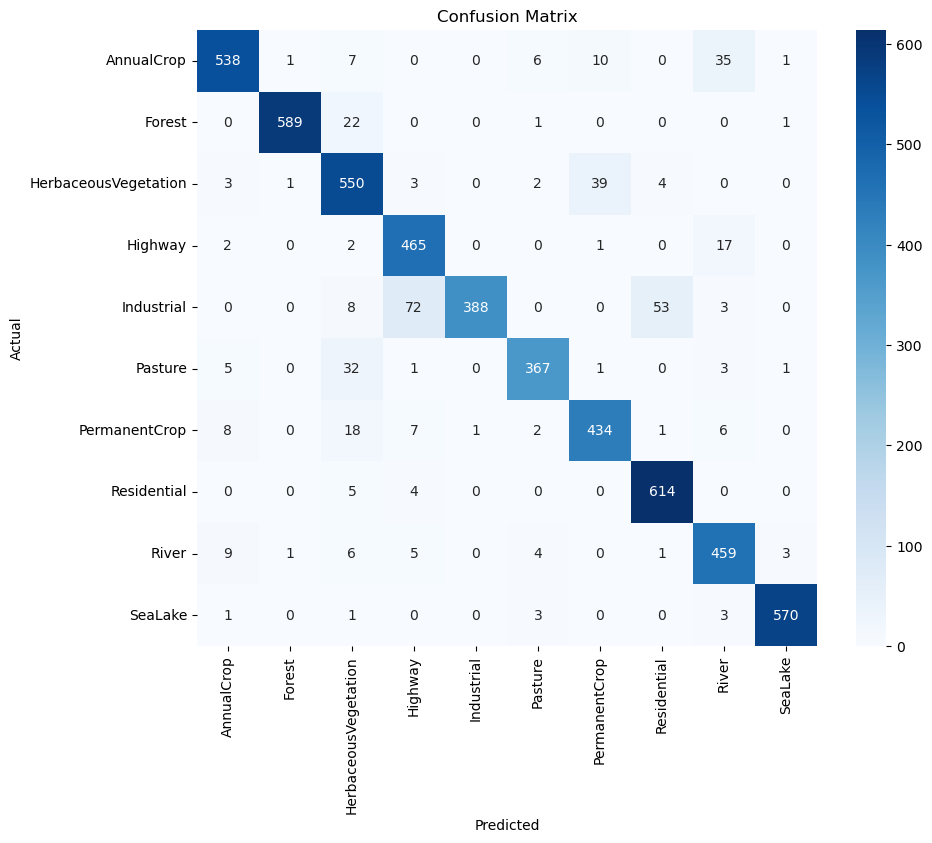

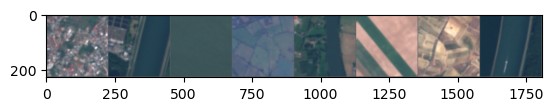

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 7 
 - Training dataset got 20258 out of 21600 images correctly (93.787%). Epoch loss: 0.188
 - Testing dataset got 5079 out of 5400 images correctly (94.056%).


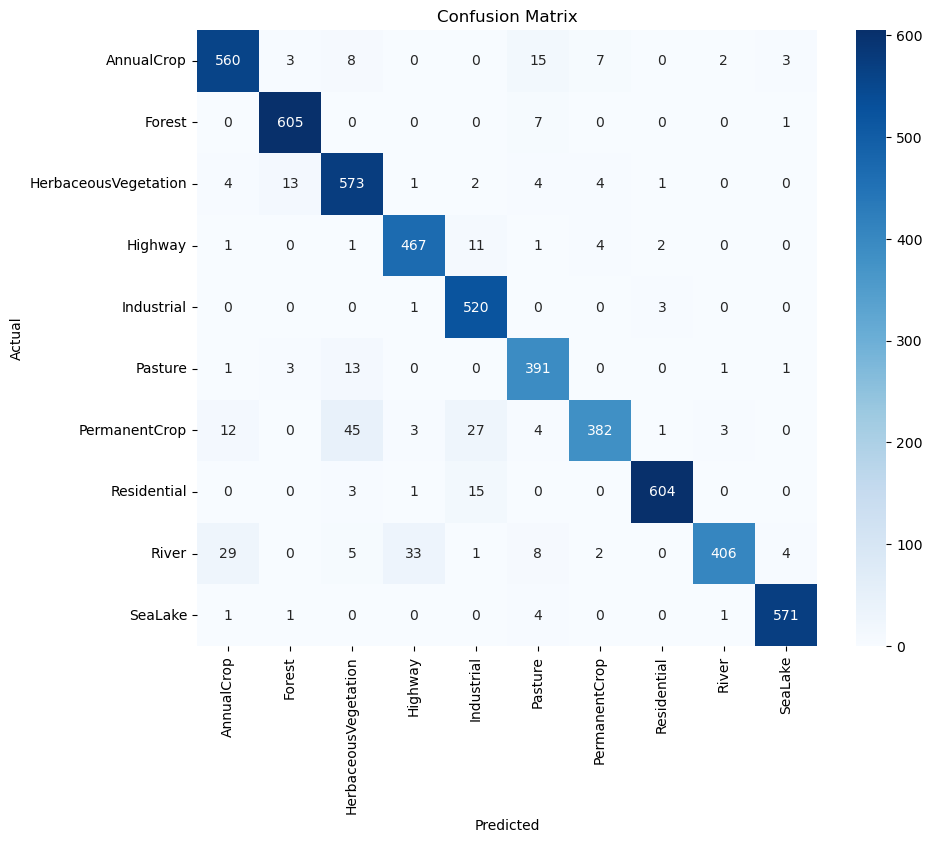

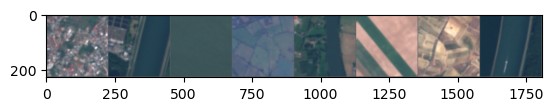

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 8 
 - Training dataset got 20311 out of 21600 images correctly (94.032%). Epoch loss: 0.184
 - Testing dataset got 5056 out of 5400 images correctly (93.630%).


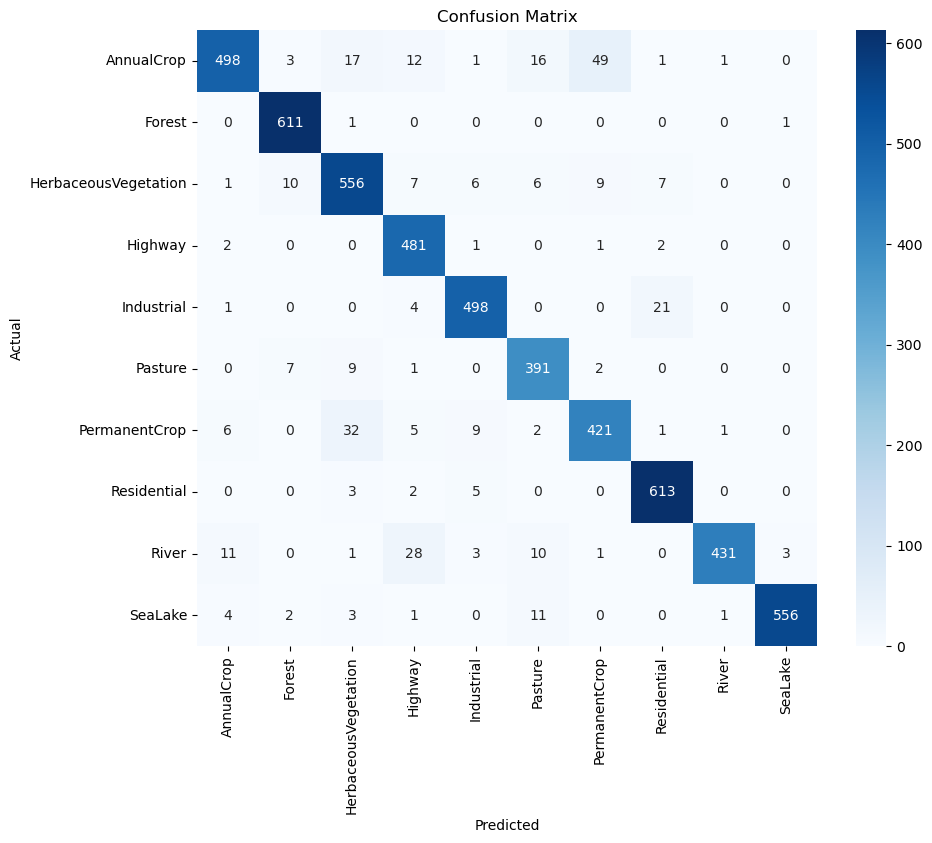

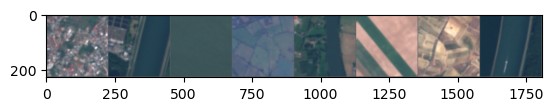

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 9 
 - Training dataset got 20443 out of 21600 images correctly (94.644%). Epoch loss: 0.169
 - Testing dataset got 4997 out of 5400 images correctly (92.537%).


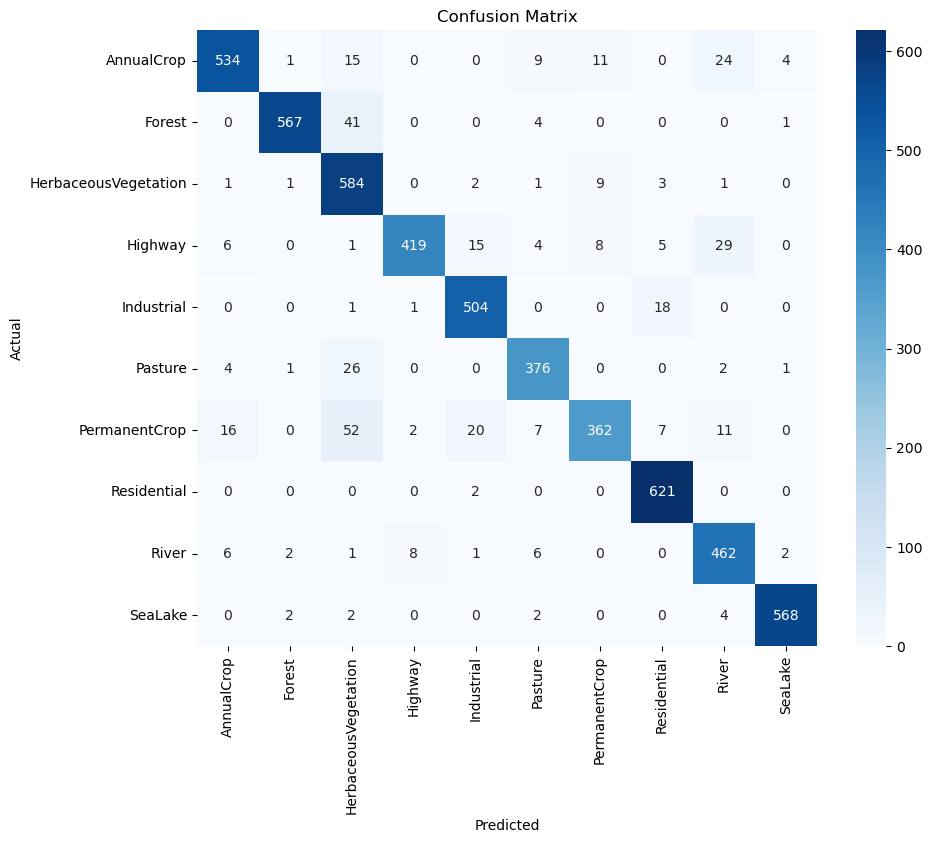

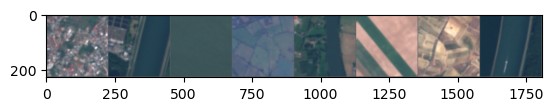

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Epoch number 10 
 - Training dataset got 20410 out of 21600 images correctly (94.491%). Epoch loss: 0.171
 - Testing dataset got 4753 out of 5400 images correctly (88.019%).


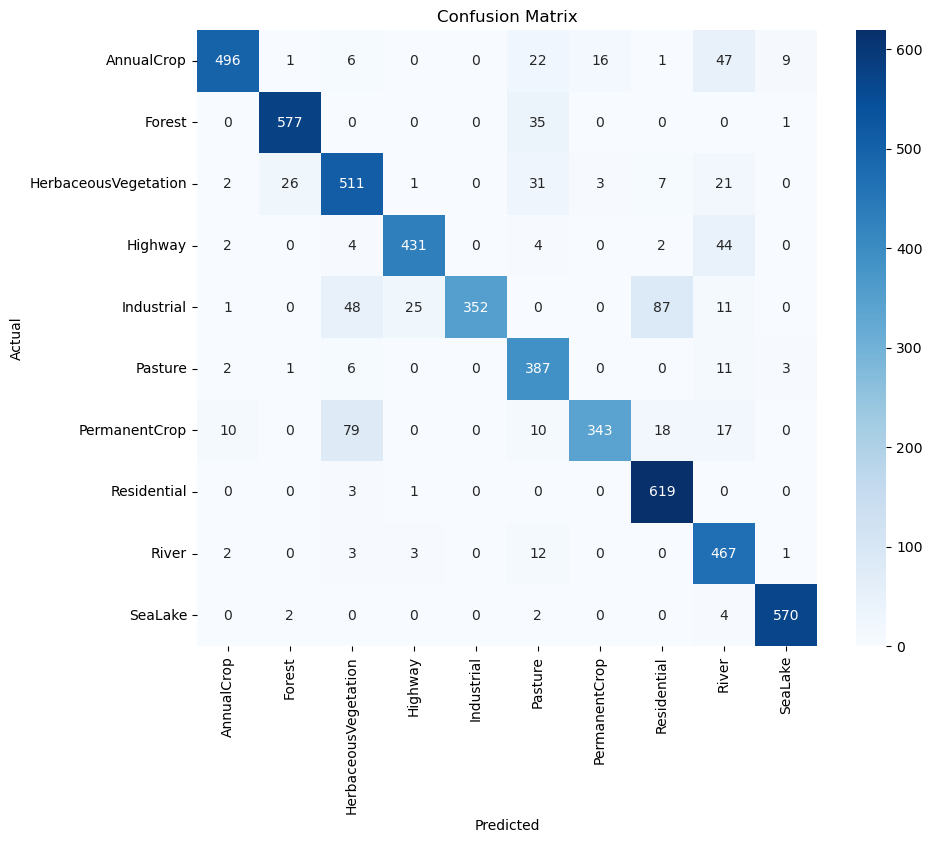

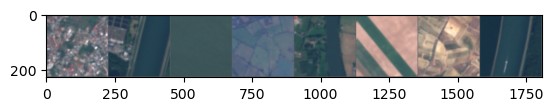

Actual: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Predicted: Residential River SeaLake Pasture River AnnualCrop PermanentCrop River
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
train_nn(resnet18_model, train_loader, test_loader, criterion, optimizer, 10, class_names)